In [105]:
import pandas as pd
import numpy as np
import seaborn as sns

In [106]:
pd.set_option("display.max_columns", None)

dfPolicyData = pd.read_csv("PolicyData.csv", delimiter = ";", encoding='latin-1')
dfPolicyData.set_index("policy_guid", inplace = True)

dfInvoiceData = pd.read_csv("InvoiceData.csv", delimiter = ";")
dfInvoiceData.set_index("invoice_guid", inplace = True)


In [107]:
# 1: Invoice is paid late
# 0: Invoice is not paid late
aLabels = [1, 0]
aConditions = [
    (dfInvoiceData["due_date"] < dfInvoiceData["paid_date"]),
    (dfInvoiceData["due_date"] >= dfInvoiceData["paid_date"])
]

dfInvoiceData["is_it_paid_late"] = np.select(aConditions, aLabels)

In [108]:
#In the dataset not all policies are ended. It s a snapshot probably around June 2018.
#There could be 3 status of policies: "Ended on time", "Terminated" and "Ongoing"
#We can build model not based on policy status, but based on number of issued invoices.

oInvocieGroupByPolicy = dfInvoiceData[["policy_guid", "is_it_paid_late"]].groupby(["policy_guid"])

dfInvoiceIssueStatistics = oInvocieGroupByPolicy.agg(["count", "sum"])

dfInvoiceIssueStatistics = dfInvoiceIssueStatistics["is_it_paid_late"] 

dfInvoiceIssueStatistics.columns = ["number_of_invoices", "number_of_late_payments"]

dfInvoiceIssueStatistics["late_payment_ratio"] = dfInvoiceIssueStatistics["number_of_late_payments"]/dfInvoiceIssueStatistics["number_of_invoices"]


dfPolicyData = dfPolicyData.join(dfInvoiceIssueStatistics)

In [110]:
# 1: Policy is paid late at least once
# 0: Policy is never paid late
aLabels = [1, 0]
aConditions = [
    (dfPolicyData["number_of_late_payments"] >= 1),
    (dfPolicyData["number_of_late_payments"] == 0)
]

dfPolicyData["is_it_paid_late"] = np.select(aConditions, aLabels)

In [111]:
# 1: Policy is still active
# 0: Policy is ended or terminated
dfPolicyData["is_policy_active"] = 0

dfPolicyData.loc[(dfPolicyData["number_of_invoices"] < dfPolicyData["Nb_of_payments"]) & (dfPolicyData["Terminated"] == 0), "is_policy_active"] = 1


In [112]:
#they are converted from object to float
dfInvoiceData["amount_premium"] = dfInvoiceData["amount_premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')
dfPolicyData["Premium"] = dfPolicyData["Premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')

dfPolicyData.info()
dfInvoiceData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68638 entries, {E4FD3CD8-4141-4E55-A74C-C983ED7EFD8E} to {81D48EF2-6ED1-4784-AE0C-9481151186F9}
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       68638 non-null  object 
 1   VehicleType                   68638 non-null  object 
 2   VehicleUsage                  68638 non-null  object 
 3   Power                         68638 non-null  int64  
 4   Weight                        68638 non-null  int64  
 5   VehicleFirstRegistrationYear  68638 non-null  int64  
 6   Mark                          68638 non-null  object 
 7   Model                         68638 non-null  object 
 8   Deductible_general            68636 non-null  float64
 9   Fire                          68638 non-null  int64  
 10  Theft                         68638 non-null  int64  
 11  Natural_disasters             68638 non-null  int64  


In [113]:
# there are 12 types of number of payments
np.sort(dfPolicyData["Nb_of_payments"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [114]:
#In policy dataset, there are some missing data that are represented either with 'Missing' or NA.

dfPolicyData[dfPolicyData.isnull().any(axis=1)]

dfMissing = dfPolicyData.astype(str) == "Missing"
dfPolicyData[dfMissing.any(axis=1)]

,Country,VehicleType,VehicleUsage,Power,Weight,VehicleFirstRegistrationYear,Mark,Model,Deductible_general,Fire,Theft,Natural_disasters,Road_assistance,Total_loss,Vandalism,Glass,Accident,Replacement_car,Gender,ClientBirthday,Region,BMClassMOD,Leasing,PolicyIssueDate,PolicyStartDate,PolicyEndDate,PolicyActualEndDate,Nb_of_payments,Premium,Channel,FuelType,avgFuelConsumption,DriveTrain,RenewalIndicator,IsRenewed,BalticRating,Terminated,sales_type,number_of_invoices,number_of_late_payments,late_payment_ratio,is_it_paid_late,is_policy_active
policy_guid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{74A1885E-CC4D-435B-B7CF-CAD0287FA814},EE,Passenger car,Regular,85,2510,2007,VOLKSWAGEN,SHARAN,191.0,1,1,1,1,1,1,1,1,0,M,1954-03-08 00:00,TARTUMAA,A1,0,2015-09-20 00:00,2015-09-20 00:00,2016-09-19 00:00,2015-10-04 00:00,12,275.24,Direct,Missing,NaN,Missing,0,1,5,1,New sale,2,1,0.500000,1,0
{FF6D78C8-B660-4D58-8A9D-0FD6E32E2A03},EE,Passenger car,Regular,77,1780,2013,SKODA,OCTAVIA,191.0,1,0,1,1,1,1,1,1,0,M,1944-07-30 00:00,JÕGEVAMAA,0,0,2015-11-23 00:00,2015-11-23 00:00,2016-11-22 00:00,2016-04-22 00:00,12,239.77,Direct,Gasoline,NaN,Missing,0,0,2,1,New sale,6,0,0.000000,0,0
{77540A90-4A76-4555-945A-D9EFC8BEF959},EE,Passenger car,Regular,120,2590,2005,VOLVO,XC90,191.0,1,1,1,1,1,1,1,1,0,M,1959-05-31 00:00,IDA-VIRUMAA,0,0,2015-09-26 00:00,2015-09-26 00:00,2016-09-25 00:00,2015-11-05 00:00,4,477.43,Direct,Diesel,NaN,Missing,0,0,3,1,New sale,1,0,0.000000,0,0
{10BF0501-6360-4AF2-BB1E-CBB4183EE432},EE,Passenger car,Regular,103,2505,2007,FORD,S-MAX,191.0,1,1,1,1,1,1,1,1,0,F,1973-05-15 00:00,PÄRNUMAA,0,0,2015-09-26 00:00,2015-09-26 00:00,2016-09-25 00:00,2016-09-25 00:00,4,245.00,Direct,Diesel,NaN,Missing,0,1,0,0,New sale,4,1,0.250000,1,0
{D57F06CB-31EA-42F6-8228-39E9DE5A3DF5},EE,Passenger car,Regular,103,2140,2006,HONDA,CR V,191.0,1,0,1,1,1,1,1,1,0,M,1960-10-10 00:00,LÄÄNE-VIRUMAA,0,0,2015-09-15 00:00,2015-09-15 00:00,2016-09-14 00:00,2016-09-14 00:00,12,265.23,Direct,Diesel,NaN,Missing,0,1,3,0,New sale,12,1,0.083333,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
{3F9628B8-AD1B-4716-86B1-9B696AC23767},EE,Passenger car,Regular,124,2050,2008,NISSAN,XTRAIL,200.0,0,0,0,0,0,0,0,0,0,M,1942-07-11 00:00,HARJUMAA,A4,0,2017-06-16 00:00,2017-06-16 00:00,2018-06-15 00:00,2018-06-15 00:00,4,525.60,Direct,Gasoline,NaN,Missing,1,0,4,0,Renewal,4,0,0.000000,0,0
{92214079-F3D2-43CF-80E7-1CA77372D087},EE,Passenger car,Regular,110,1990,2005,HONDA,CR V,200.0,0,0,0,0,0,0,0,0,0,M,1963-05-18 00:00,PÕLVAMAA,A2,0,2017-08-14 00:00,2017-08-14 00:00,2018-08-13 00:00,2018-08-13 00:00,2,319.48,Direct,Gasoline,NaN,Missing,1,0,4,0,Renewal,2,1,0.500000,1,0
{A38D64CE-810B-4692-A868-CD16B897FA31},EE,Tractor,ATV,36,470,2007,OTHER,LT-A700XK7,400.0,1,1,0,0,0,0,0,0,0,M,1979-08-16 00:00,JÕGEVAMAA,A2,0,2017-07-30 00:00,2017-07-30 00:00,2018-07-29 00:00,2018-07-29 00:00,4,110.01,Direct,Gasoline,NaN,Missing,1,0,2,0,Renewal,3,3,1.000000,1,1


In [115]:
#There is no missing data in invoice dataset.

dfMissing = dfInvoiceData.astype(str) == "Missing"
dfInvoiceData[dfMissing.any(axis=1)]

dfInvoiceData[dfInvoiceData.isnull().any(axis=1)]

,payment_status,policy_guid,amount_premium,due_date,paid_date,is_it_paid_late
invoice_guid,,,,,,


In [144]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={'figure.figsize':(11.7,8.27)})

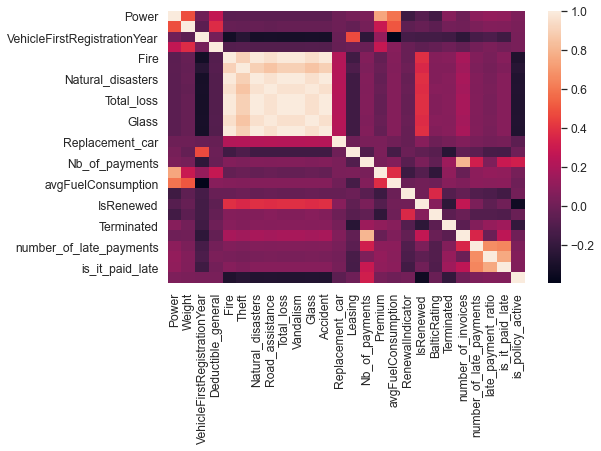

In [141]:
dfCorr = dfPolicyData.corr()
sns.heatmap(dfCorr)

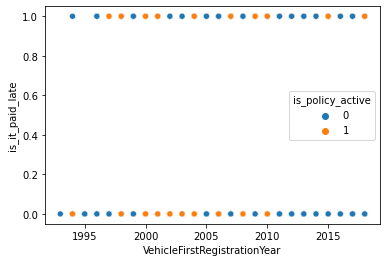

In [123]:
sns.scatterplot(data =dfPolicyData , x= "VehicleFirstRegistrationYear", y = "is_it_paid_late" , hue = "is_policy_active")


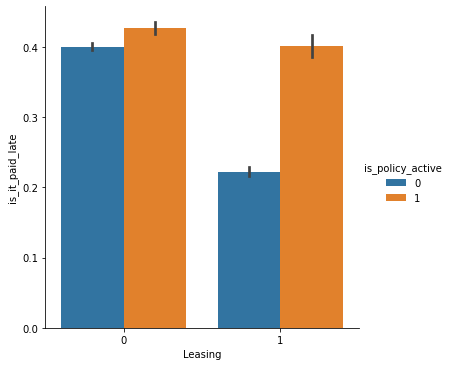

In [130]:
sns.catplot(data =dfPolicyData ,kind="bar", x= "Leasing", y = "is_it_paid_late" , hue = "is_policy_active")

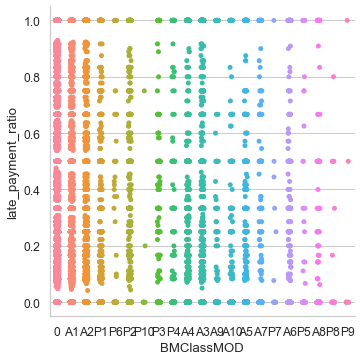

In [145]:
sns.catplot(x="BMClassMOD", y="late_payment_ratio", data=dfPolicyData)

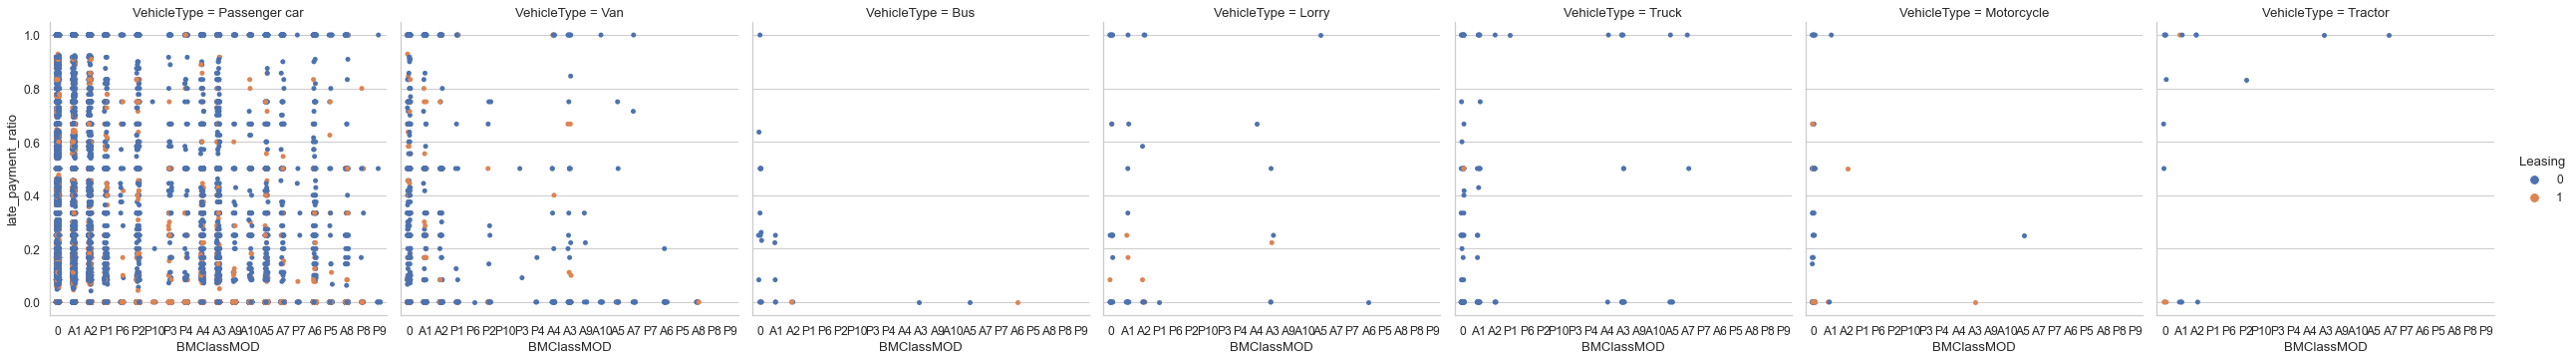

In [149]:
sns.catplot(x="BMClassMOD", y="late_payment_ratio", hue="Leasing", col = "VehicleType", data=dfPolicyData)

array(['TOYOTA', 'VOLVO', 'VOLKSWAGEN', 'SKODA', 'OPEL', 'FORD', 'HONDA',
       'NISSAN', 'MAZDA', 'SUBARU', 'MERCEDES BENZ', 'LEXUS', 'AUDI',
       'PEUGEOT', 'KIA', 'BMW', 'MITSUBISHI', 'SUZUKI', 'CITROEN', 'MINI',
       'FIAT', 'CHEVROLET', 'RENAULT', 'SAAB', 'CHRYSLER', 'HYUNDAI',
       'JEEP', 'OTHER', 'DACIA', 'PORSCHE', 'SEAT', 'LANCIA',
       'LAND ROVER', 'SSANGYONG', 'JAGUAR', 'SCANIA', 'INFINITI', 'DODGE',
       'CADILLAC', 'LINCOLN', 'ISUZU', 'LADA', 'YAMAHA', 'KTM', 'DUCATI',
       'MASSEY FERGUS', 'IVECO', 'SCANIA IRIZAR', 'ALFA ROMEO',
       'MICROCAR', 'HARLEY-DAVIDS', 'APRILIA', 'BUELL', 'KAWASAKI',
       'MOTO STAR', 'JOHN DEERE', 'MAN', 'VALTRA', 'CFMOTO', 'GMC',
       'HUMMER', 'RSM', 'ROVER', 'SATURN', 'NEW HOLLAND', 'FENDT', 'VAZ',
       'DAF', 'TEMSA'], dtype=object)